# 2023-08-05__AdEx_Nto1_we_sweep

(We've made Nto1AdEx.jl now).

Let's do an unholy python julia brian hybrid.

(plotting (and nb restarting) in julia still too slow startup).  
But sim is almost 1000x faster than brian.

In [1]:
%%time
from brian2.units import *

CPU times: total: 984 ms
Wall time: 2.7 s


In [2]:
%%time
%run lib/plot.py

Importing mpl, brian … ✔
CPU times: total: 0 ns
Wall time: 18.8 ms


https://github.com/JuliaPy/pyjulia

In [3]:
%%time
from julia import Pkg

CPU times: total: 3.16 s
Wall time: 5.34 s


In [4]:
%%time
Pkg.activate("..")
# Pkg.status()
# output is in nb terminal

CPU times: total: 1.03 s
Wall time: 2.26 s


In [5]:
%%time
from julia import Nto1AdEx

CPU times: total: 516 ms
Wall time: 1.19 s


In [6]:
%%time
out = Nto1AdEx.sim(6500, 10);

CPU times: total: 375 ms
Wall time: 1.15 s


(First run: 1.3 seconds)

In [7]:
V = (out.V * volt)

array([-65.        , -64.99986538, -64.99623327, ..., -54.53301958,
       -54.51563329, -54.49719995]) * mvolt

In [8]:
%run lib/util.py

Importing mpl, brian … ✔
Importing pandas … ✔


In [9]:
V = ceil_spikes_jl(out)

array([-65.        , -64.99986538, -64.99623327, ..., -54.53301958,
       -54.51563329, -54.49719995]) * mvolt

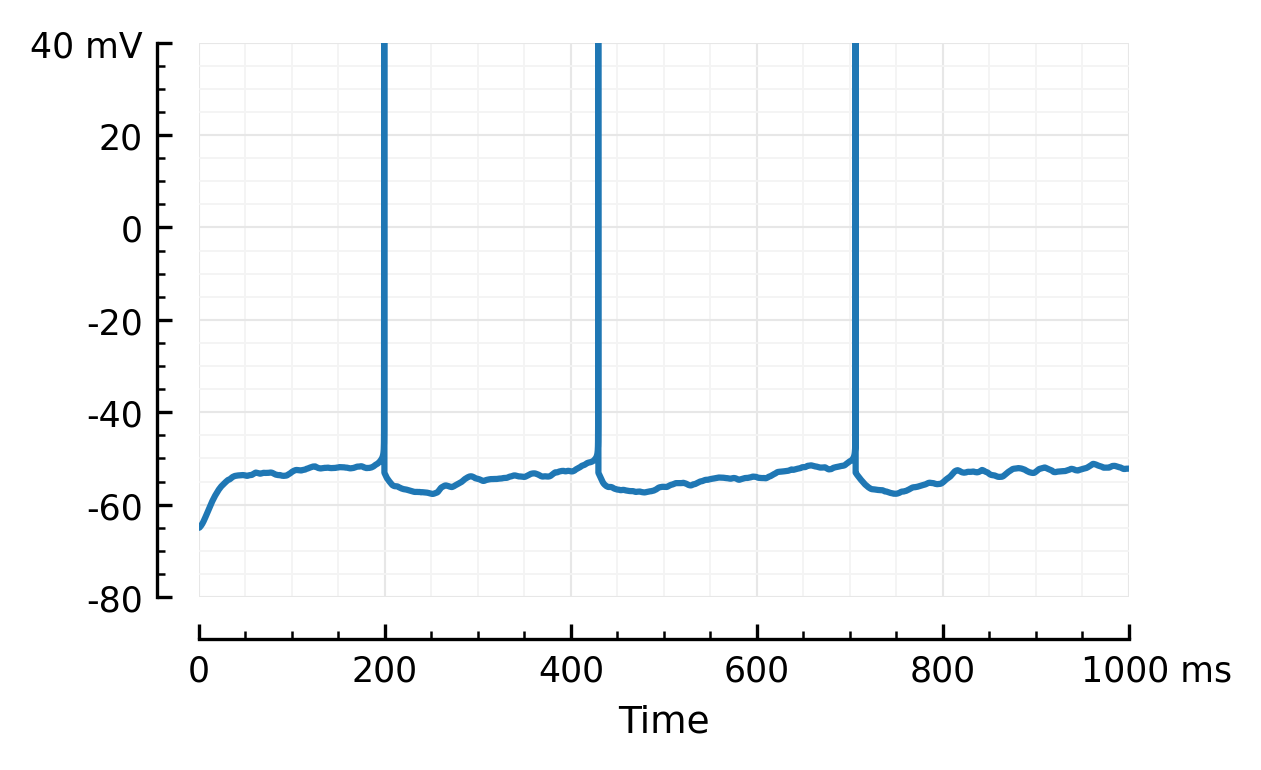

In [10]:
plotsig(V, tlim=[0,1000]*ms);

In [11]:
%run lib/diskcache.py

In [12]:
N = 6500
T = 10 * second

@cache("2023-08-05__AdEx_Nto1_we_sweep")
def sim(wₑ, seed):
    out = Nto1AdEx.sim(N, T / second, seed, wₑ / siemens);
    v = ceil_spikes_jl(out)
    return dict(
        wₑ   = wₑ,
        seed = seed,
        median_Vm   = median(v),
        output_rate = out.spikerate * Hz,
    )

In [29]:
wₑs = [0, 2.5, 5, 7.5, 10, 11, 12, 12.5, 13, 14, 15, 16, 17.5, 20, 22.5, 25, 27.5, 30] * pS
# wₑs = [0, 5, 10, 15, 30] * pS
seeds = range(10);
# seeds = [2]

In [30]:
# from tqdm import tqdm

In [32]:
data = []
for wₑ in (wₑs):
    for seed in (seeds):
        d = sim(wₑ, seed)
        data.append(d)

In [33]:
df = pd.DataFrame(data)
df.head()

,we,seed,median_Vm,output_rate
0,0. S,0,-64.99999991 mV,0. Hz
1,0. S,1,-64.99999991 mV,0. Hz
2,0. S,2,-64.99999991 mV,0. Hz
3,0. S,3,-64.99999991 mV,0. Hz
4,0. S,4,-64.99999991 mV,0. Hz


In [34]:
df = units_to_header(df)

,we_pS,seed,median_Vm_mV,output_rate_Hz
0,0.0,0,-65.000000,0.0
1,0.0,1,-65.000000,0.0
2,0.0,2,-65.000000,0.0
3,0.0,3,-65.000000,0.0
4,0.0,4,-65.000000,0.0
...,...,...,...,...
175,30.0,5,-53.365445,12.7
176,30.0,6,-53.325009,12.5
177,30.0,7,-53.339397,12.1
178,30.0,8,-53.243763,11.8


In [22]:
# (`!mkdir -p data` not working in IJulia)

In [35]:
!mkdir data
df.to_csv("data/2023-08-05__AdEx_Nto1_we_sweep.csv")

A subdirectory or file data already exists.


In [340]:
df = pd.read_csv("data/2023-08-05__AdEx_Nto1_we_sweep.csv", index_col=0);

In [341]:
# groupby no work w/ brian units
df.groupby("we_pS").mean()

,seed,median_Vm_mV,output_rate_Hz
we_pS,,,
0.0,4.5,-65.000000,0.00
2.5,4.5,-60.760530,0.00
5.0,4.5,-57.772544,0.00
7.5,4.5,-55.545334,0.00
10.0,4.5,-53.767998,0.00
11.0,4.5,-53.241056,0.35
12.0,4.5,-53.253564,1.44
12.5,4.5,-53.429906,2.05
13.0,4.5,-53.535252,2.46


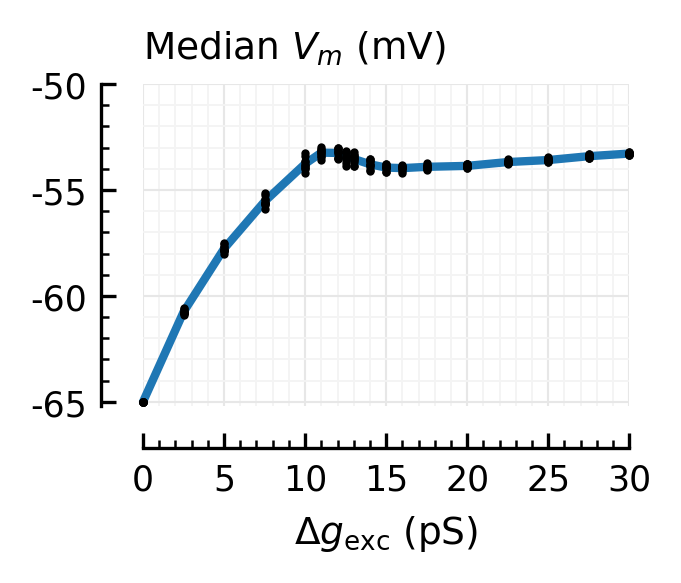

In [342]:
def plot_dots_and_means(x, y, ax = None, **kw):
    xu = unique(x)
    ym = [mean(y[x == xi]) for xi in xu]
    plot(xu, ym, "-", lw=2, ax=ax, **kw, clip_on=False)
    plot(x, y, "k.", ms=4, mfc='k', mec='none', ax=ax, **kw, clip_on=False)
    
fig, ax = plt.subplots(figsize=(0.9*mw, 0.6*mw))
xlim = [0, 30]
plot_dots_and_means(df.we_pS, df.median_Vm_mV, ax, xlim=xlim, ylim=[-65.2, -50])
hylabel(ax, "Median $V_m$ (mV)")
xl = "$Δg_\\mathrm{exc}$ (pS)"
plt.xlabel(xl);

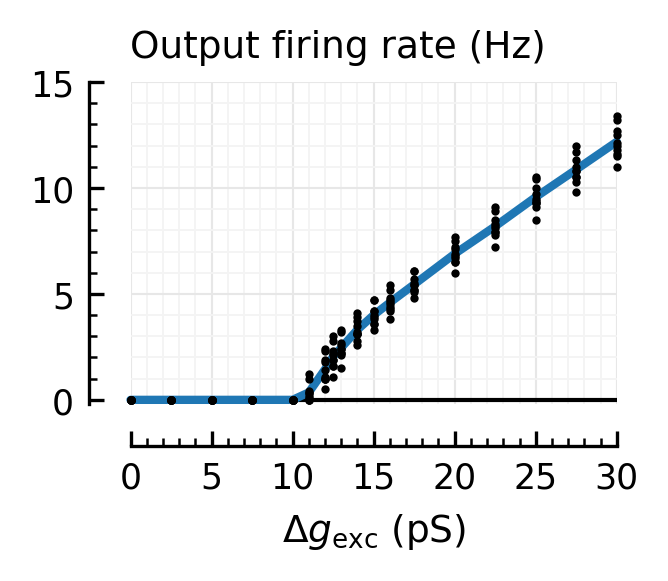

In [343]:
fig, ax = plt.subplots(figsize=(0.9*mw, 0.6*mw))
plt.axhline(0, 0, 1, c="black", lw=1)
plot_dots_and_means(df.we_pS, df.output_rate_Hz, ax, ylim=[-0.2, 15], xlim=xlim)
hylabel(ax, "Output firing rate (Hz)")
plt.xlabel(xl);

Saved at `../thesis/figs/input_drive_we.pdf`


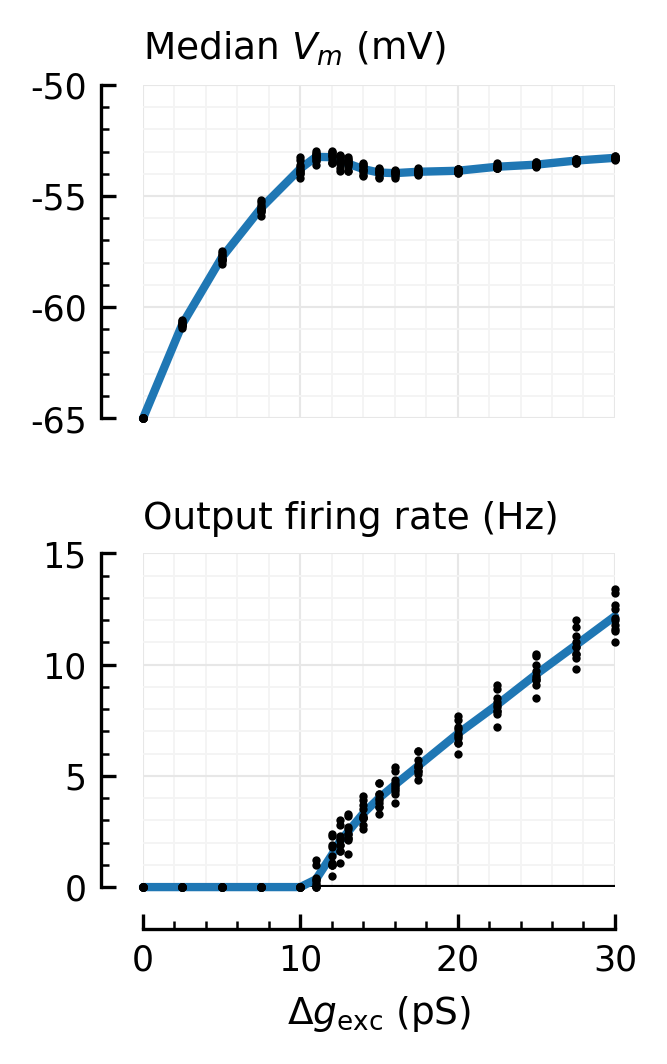

In [344]:
fig, axs = plt.subplots(figsize=(1*mw, 1.5*mw), nrows=2)
axs[1].axhline(0, 0, 1, c="black", lw=1)
plot_dots_and_means(df.we_pS, df.median_Vm_mV, axs[0], xlim=xlim, ylim=[-65, -50], nbins_x=4)
plot_dots_and_means(df.we_pS, df.output_rate_Hz, axs[1], xlim=xlim, ylim=[-0, 15], nbins_x=4)
hylabel(axs[0], "Median $V_m$ (mV)")
hylabel(axs[1], "Output firing rate (Hz)")
rm_ticks_and_spine(axs[0])
plt.tight_layout(h_pad=1.4)
axs[1].set_xlabel(xl);
savefig_thesis("input_drive_we")

## Now, for diff N

First, which N finally chosen.  
Something ± looking evenly spaced on log scale.  
(but maybe also nice integers).

In [179]:
Ns = [10, 20, 45, 100, 200, 400, 800, 1600, 3200, 6500]
Nₑs = array(Ns) * 4/5

array([   8.,   16.,   36.,   80.,  160.,  320.,  640., 1280., 2560.,
       5200.])

In [180]:
%run lib/plot.py

importing mpl … ✔
importing brian … ✔


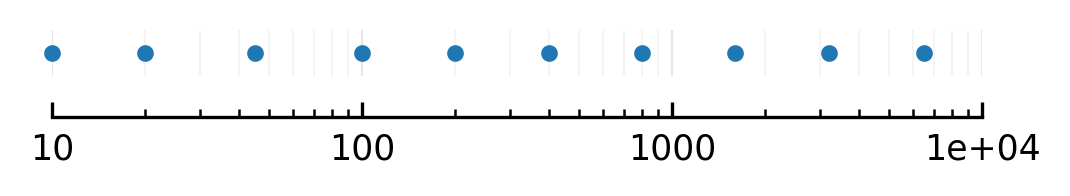

In [181]:
plot(Ns, [1]*len(Ns), ".", xscale="log", fs=(4, 0.2), ytype="off");

Or if you want less sims to run, a subset:

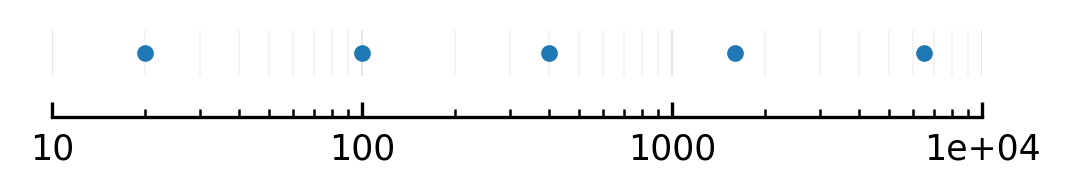

In [183]:
Ns2 = [20, 100, 400, 1600, 6500];

plot(Ns2, [1]*len(Ns2), ".", xscale="log", fs=(4, 0.2), ytype="off");

Seeds for search:

In [195]:
w0 = lambda N: 15 * pS * (6500 / N)

w0s = [w0(N) for N in Ns]

[9.75 * nsiemens,
 4.875 * nsiemens,
 2.16666667 * nsiemens,
 0.975 * nsiemens,
 0.4875 * nsiemens,
 243.75 * psiemens,
 121.875 * psiemens,
 60.9375 * psiemens,
 30.46875 * psiemens,
 15. * psiemens]

In [202]:
from scipy.optimize import root_scalar

In [246]:
def avg_spikerate(N, w, nseeds = 10, T = 10*second):
    R = 0
    for seed in range(nseeds):
        sim = Nto1AdEx.sim(N, T/second, seed, w)
        R += sim.spikerate
        
    return R / nseeds * Hz

def f(w, N, target_fr = 4.0*Hz):
    fr = avg_spikerate(N, w)
    return (fr - target_fr) / Hz

wₑs = []

for (N, w0) in zip(Ns, w0s):
    # Scipy no work w/ brian units:
    w0 = w0/siemens  # `/=` no work..
    print(f"{N=}")
    print(f"Init: {w0*siemens} → {avg_spikerate(N, w0)}")
    print("Finding root", end=" … ")
    sol = root_scalar(f, bracket=[w0/4, w0*4], args=(N,), xtol=w0/1000)
    print(f"✔ ({sol.iterations=})")
    print(f"Found: {sol.root*siemens} → {avg_spikerate(N, sol.root)}")
    wₑs.append(sol.root*siemens)
    print("")

N=10
Init: 9.75 nS → 24.48 Hz
Finding root … ✔ (sol.iterations=6)
Found: 2.83884334 nS → 3.99 Hz

N=20
Init: 4.875 nS → 18.11 Hz
Finding root … ✔ (sol.iterations=5)
Found: 1.85624115 nS → 4. Hz

N=45
Init: 2.16666667 nS → 13.27 Hz
Finding root … ✔ (sol.iterations=7)
Found: 1.052897 nS → 4.01 Hz

N=100
Init: 0.975 nS → 9.97 Hz
Finding root … ✔ (sol.iterations=6)
Found: 0.58695123 nS → 4. Hz

N=200
Init: 0.4875 nS → 7.84 Hz
Finding root … ✔ (sol.iterations=5)
Found: 0.33519511 nS → 4.01 Hz

N=400
Init: 243.75 pS → 6.85 Hz
Finding root … ✔ (sol.iterations=8)
Found: 183.88420978 pS → 4. Hz

N=800
Init: 121.875 pS → 5.83 Hz
Finding root … ✔ (sol.iterations=6)
Found: 100.2994751 pS → 4. Hz

N=1600
Init: 60.9375 pS → 4.73 Hz
Finding root … ✔ (sol.iterations=9)
Found: 55.84664628 pS → 4.01 Hz

N=3200
Init: 30.46875 pS → 4.46 Hz
Finding root … ✔ (sol.iterations=9)
Found: 29.04560215 pS → 4. Hz

N=6500
Init: 15. pS → 4. Hz
Finding root … ✔ (sol.iterations=11)
Found: 15.03590947 pS → 4. Hz



In [324]:
frs = [avg_spikerate(N, w/siemens) for (N,w) in zip(Ns, wₑs)];

In [331]:
factor = array(w0s) / array(wₑs);

In [332]:
df = units_to_header(pd.DataFrame(dict(N=Ns, we=wₑs, fr=frs, factor=factor)))

,N,we_nS,fr_Hz,factor
0,10,2.838843,3.99,3.434497
1,20,1.856241,4.00,2.626275
2,45,1.052897,4.01,2.057814
3,100,0.586951,4.00,1.661126
4,200,0.335195,4.01,1.454377
5,400,0.183884,4.00,1.325562
6,800,0.100299,4.00,1.215111
7,1600,0.055847,4.01,1.091158
8,3200,0.029046,4.00,1.048997
9,6500,0.015036,4.00,0.997612


In [333]:
df.to_csv("data/2023-08-05__AdEx_Nto1__wₑs_for_4Hz_for_all_N.csv")

Saved at `../thesis/figs/we-for-4Hz-for-all-N.pdf`


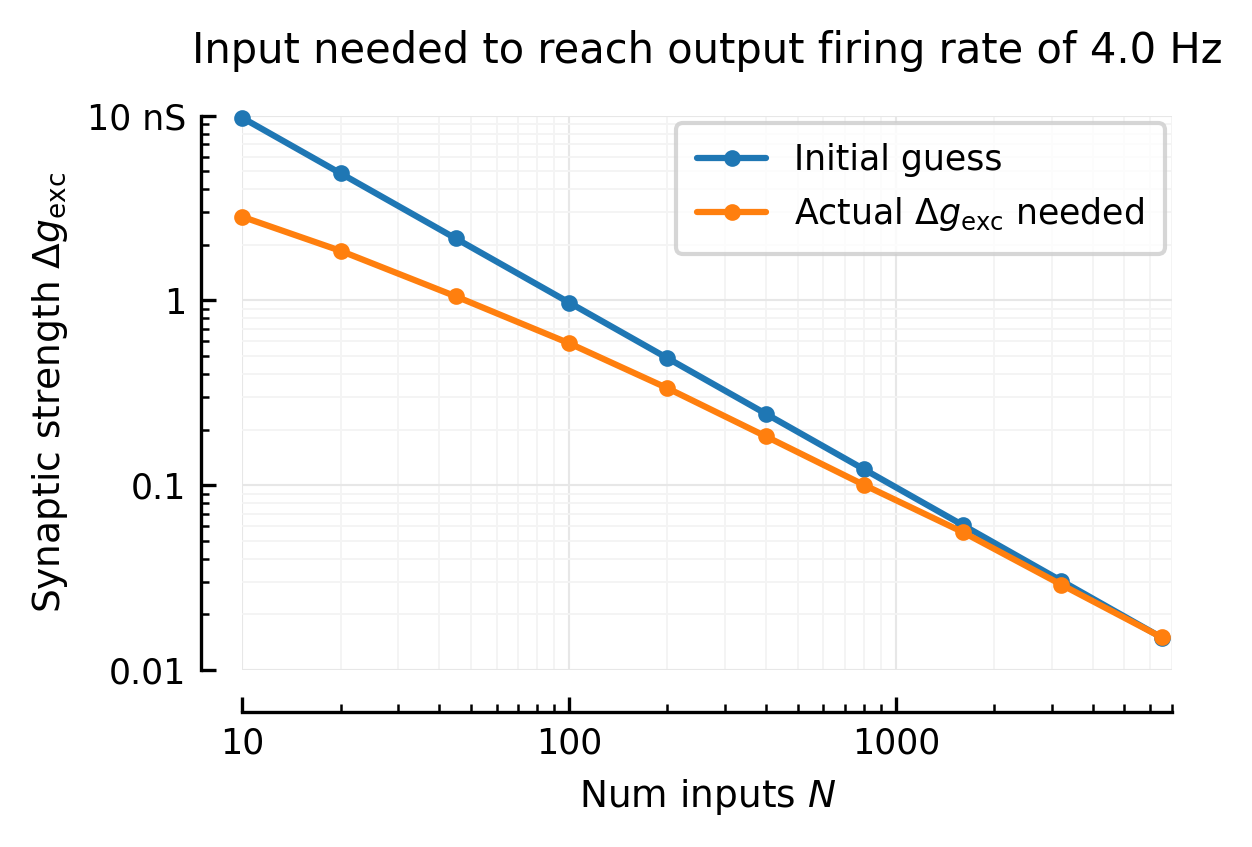

In [321]:
fig, ax = plt.subplots()
Δw = "$\Delta g_\mathrm{exc}$"
sett(ax, ylim=[0.01, 10], xlim=[10, 7000], xlabel="Num inputs $N$", ylabel=f"Synaptic strength {Δw}")
plot(Ns, w0s, ".-", xscale="log", yscale="log", ax=ax, label="Initial guess")
plot(Ns, wₑs, ".-", ax=ax, label=f"Actual {Δw} needed");
ax.set_title("Input needed to reach output firing rate of 4.0 Hz", y=1.05)
ax.legend();
savefig_thesis("we-for-4Hz-for-all-N")